## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

In [2]:
 class Line():
    """
    Stores information about left and right lane lines for comparison between video frames 
    """
    def __init__(self):
        #Has the line been detected in previous frame(s)
        self.detected = False
        #Coordinates of all points along line
        self.curr_fit = None
        #Fit data from previous frame
        self.prev_fit = None
        #X-intercepts for fitted lines
        self.curr_fitx = None
        #Fitx data from previous frame
        self.prev_fitx = None
        #Array to store difference between current and previous fits
        self.diffs = np.array([0,0,0], dtype='float')
        #Array to store difference between current and previous x fits
        self.diffsx = np.array([0,0,0], dtype='float')
        #Curvature of the line
        self.curvature = None
        
    def addFit(self, fit):
            
        #if fit was detected in previous frame
        if self.detected:
            #Calculate difference
            self.diffs = abs(fit-self.curr_fit)
        
            #Ensure new fit is within acceptable margin of previous fit - rejects outliers
            if self.diffs[0] < 0.001 and self.diffs[1] < 1.0 and self.diffs[2] < 100.0:
                self.curr_fit = np.mean(fit, fit, self.prev_fit)
                self.detected = True
                self.prev_fit = self.curr_fit
            else:
                #Use previous fit
                self.detected = False
                self.curr_fit = self.prev_fit
        else:
            #if no previous fit detected, use current fit
            self.curr_fit = fit
            self.prev_fit = fit
        
    
    def addFitx(self, fitx):
            
        #if fitx was detected in previous frame
        if self.detected:
            #Calucalte difference in fitx
            self.diffsx = abs(fitx-self.curr_fitx)

            #Ensure new fitx is within acceptable margin of previous fitx - rejects outliers
            if self.diffsx[0] < 0.001 and self.diffsx[1] < 1.0 and self.diffsx[2] < 100.0:
                self.curr_fitx = np.mean(fitx, fitx, self.prev_fitx)
                self.detected = True
                self.prev_fitx = self.curr_fitx
            else:
                #Use previous fitx
                self.detected = False
                self.curr_fitx = self.prev_fitx
        else:
            #if no previous fitx detected, use current fitx
            self.curr_fitx = fitx
            self.prev_fitx = fitx
    
    def addCurve(self, curve):
        #Store curve data
        self.curvature = curve
      
    def isDetected(self):
        #Return if line has been found
        return self.detected
    
    def getFitx(self):
        #Return fitx array
        return self.curr_fitx
    
    def getFit(self):
        #Return fit array
        return self.curr_fit
        
    def getCurve(self):
        #Return curve value
        return self.curvature 

In [3]:
def undistort(img, objpts, imgpts):
    """
    Undistort image based on objectpoints and image points
    found in chessboard calibrations
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

            
def sobelThresh(img_channel, s_thresh, sx_thresh):
    """
    Calculates gradient of image to be used to detect edges.
    """
    #Apply x gradient to emphasize verticle lines
    sobelx = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 1, 0))
    #Resize to an 8-bit integer
    scaled_sobel = np.uint8(255*sobelx/np.max(sobelx))
    
    #Create binary image based on X-Gradient
    sobel = np.zeros_like(scaled_sobel)
    sobel[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    #Create binary image based on Sobel only
    chanThresh = np.zeros_like(img_channel)
    chanThresh[(img_channel >= s_thresh[0]) & (img_channel <= s_thresh[1])] = 1
    
    #Combine x-gradient and sobel binary image
    combined = np.zeros_like(chanThresh)
    combined[(chanThresh == 1) | (sobel == 1)] = 1
    
    return combined


def threshold(img, s_thresh=(170,255), sx_thresh=(20,100)):
    """
    Creates a thresholded binary image based on color transforms
    and gradients.
    """
    
    #RGB color space
    B_channel = img[:,:,2] #Clear lines on some images, low-moderate noise
    B_channel = sobelThresh(B_channel, (220,255), (20,100))
    
    #HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S_channel = hls[:,:,2] #Clear lines on all images, low noise
    S_channel = sobelThresh(S_channel, s_thresh, sx_thresh)
    
    #HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:,:,2] #Clear lines on most images, low-moderate noise
    v_channel = sobelThresh(v_channel, (220,255), (20,100))
    
    #LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel = lab[:,:,0] #Clear lines on most images, low-moderate noise
    l_channel = sobelThresh(l_channel, (210,255), (20,100))
    
    #Combine the best channels from each color space
    thresh = np.zeros_like(S_channel)
    thresh[(S_channel == 1) | (B_channel == 1) | (v_channel == 1) | (l_channel == 1)] = 1
    
    return thresh


def perspectiveTransform(img):
    """
    Warps an image to create a bird's eye view of the lane for use 
    in calculating the curvature of the lane.
    """
    
    #Get image data
    max_y = img.shape[0]
    max_x = img.shape[1]
    img_size = (max_x, max_y)
    
    #Create source image points
    src = np.float32([[max_x*0.465, max_y*0.625], #top left
                     [max_x*0.156, max_y],      #bottom left
                     [max_x*0.879, max_y],     #bottom right
                     [max_x*0.539, max_y*0.625]]) #top right
    
    #Create destination image points
    dst = np.float32([[max_x*0.234,0],
                     [max_x*0.234, max_y],
                     [max_x*0.742, max_y],
                     [max_x*0.742, 0]])
    
    #Get matrix to show how to transform image from source to destination points
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #Warp the image
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M, Minv


def find_lane_pixels(binary_warped, Lline, Rline):
    """
    Fit lines to left and right lanes when there is no
    previous lane data
    """
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 20
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 75

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)

        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #Create fitted lines
    Lfit = np.polyfit(lefty, leftx, 2)
    Rfit = np.polyfit(righty, rightx, 2)
    
    #Add fitted lines to left and right lines
    Lline.addFit(Lfit)
    Rline.addFit(Rfit)

    return Lfit, Rfit


def fit_poly(img_shape, leftx, lefty, rightx, righty, Lline, Rline):
    """
    Calculate line fit and curvature for frames with previous line data
    """
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #Add fitted lines to left and right lines
    Lline.addFit(left_fit)
    Rline.addFit(right_fit)
     
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    #Calculate both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ##Calculate Lane Curvature## 
    
    #Convert pixels to meters
    ym_per_pix = 30/720
    xm_per_pix = 3.7/650
    
    #Calculate fits with real-world measurements
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    #Set real-world y value
    y_eval = np.max(lefty) * ym_per_pix
    
    #Calculate curve values for each line
    left_curve =  ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curve =  ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    #Round curve value to the nearest integer
    left_curve = int(round(left_curve))
    right_curve = int(round(right_curve))
    
    #if both lines fitted, calculate distance from lane center
    if left_fitx is not None and right_fitx is not None:
        #True center of image - represents where the car is
        img_center = img_shape[0] * xm_per_pix
        #Real world integer value of the lines location
        Lfit_int = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
        Rfit_int = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
        #Shows where the line center is in the image
        car_position = (Rfit_int + Lfit_int) / 2
        #Determine distance from the center of the frame to the center of the lane
        center_dist = (img_center - car_position)
        #Round answer to two decimal places
        center_dist = round(center_dist, 2)
        
    ##End Calculate Lane Curvature## 

    return left_fitx, right_fitx, ploty, left_curve, right_curve, center_dist


def search_around_poly(binary_warped, Lline, Rline):
    """
    Fit lines when prior lane data exits
    """
    
    #Width of margin to search around in the previous fit
    margin = 50
    
    #Get prior lane data
    left_fit = Lline.getFit()
    right_fit = Rline.getFit()
    
    # Grab activated pixels in thresholded image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    #Set the area of search based on activated x-values
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) +
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) +
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    #extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_curve, right_curve, center = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty, Lline, Rline)

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    #Save fitx data
    Lline.addFitx(left_fitx)
    Rline.addFitx(right_fitx)
    
    #Save line curvatures
    Lline.addCurve(left_curve)
    Rline.addCurve(right_curve)

    return result, ploty, center

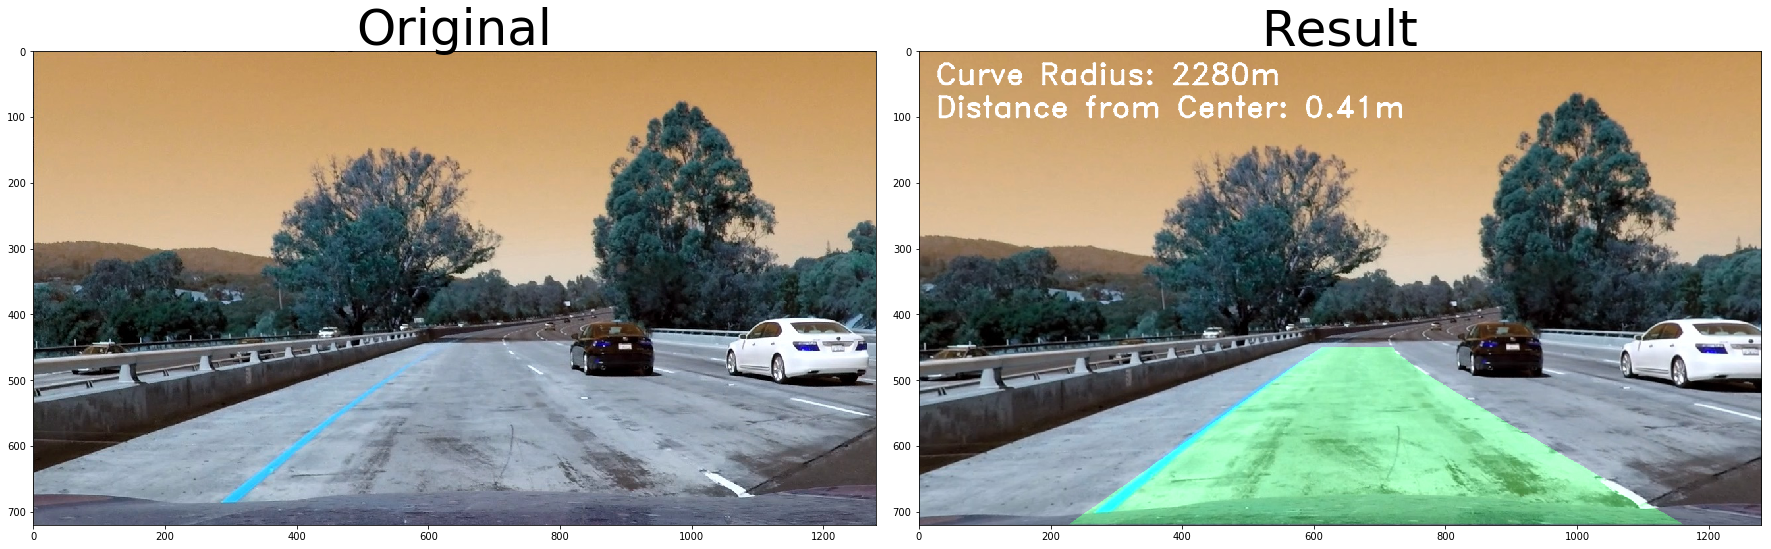

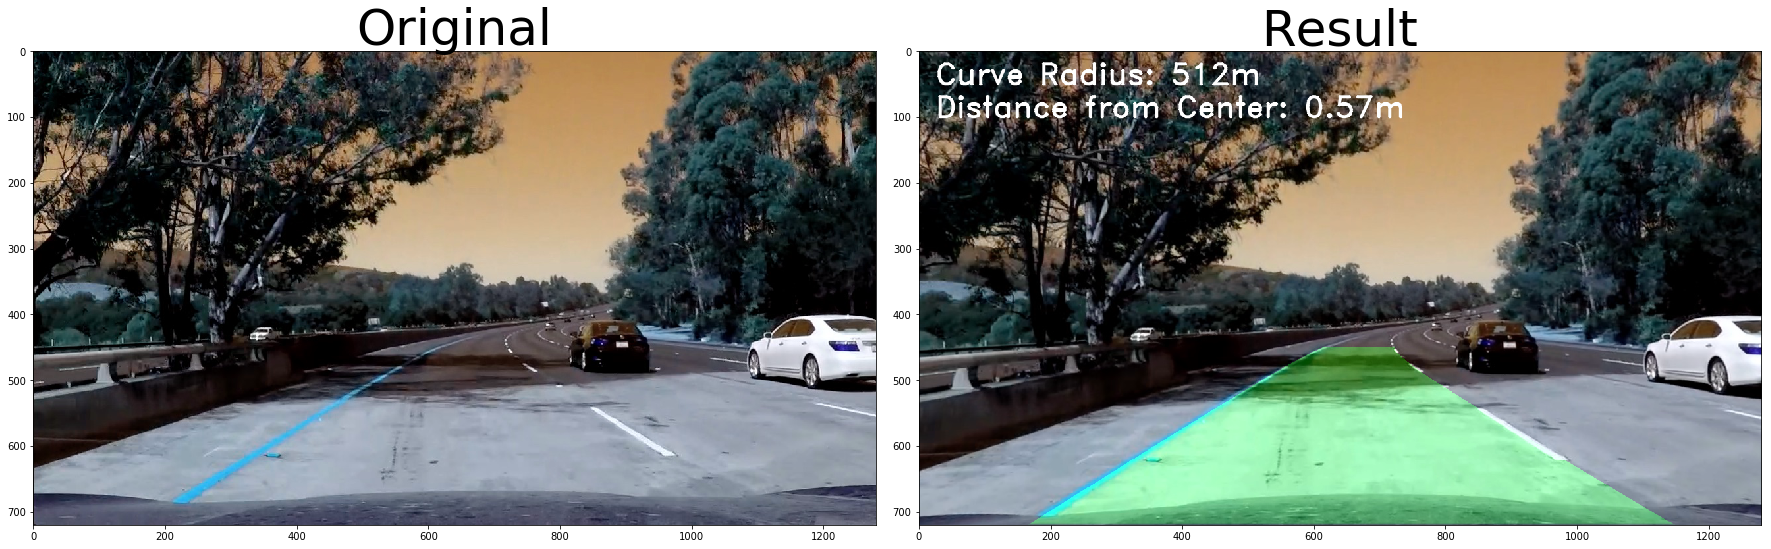

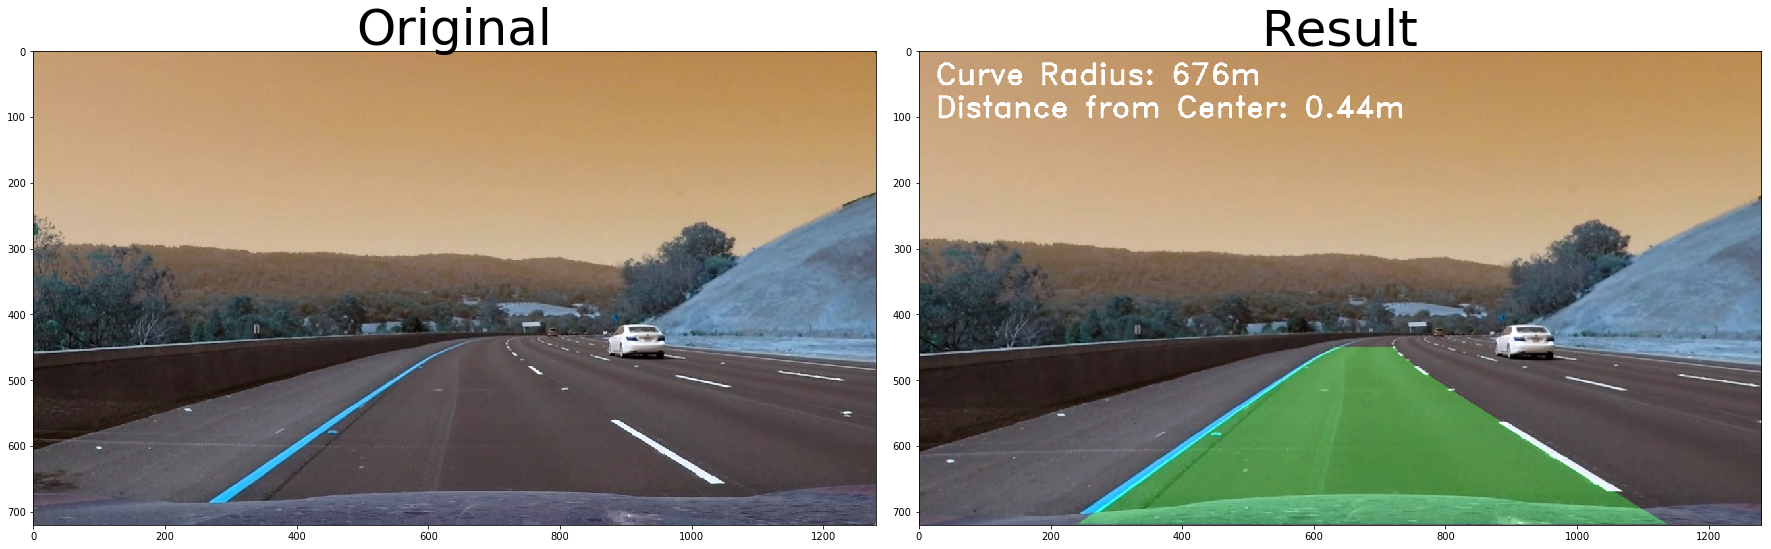

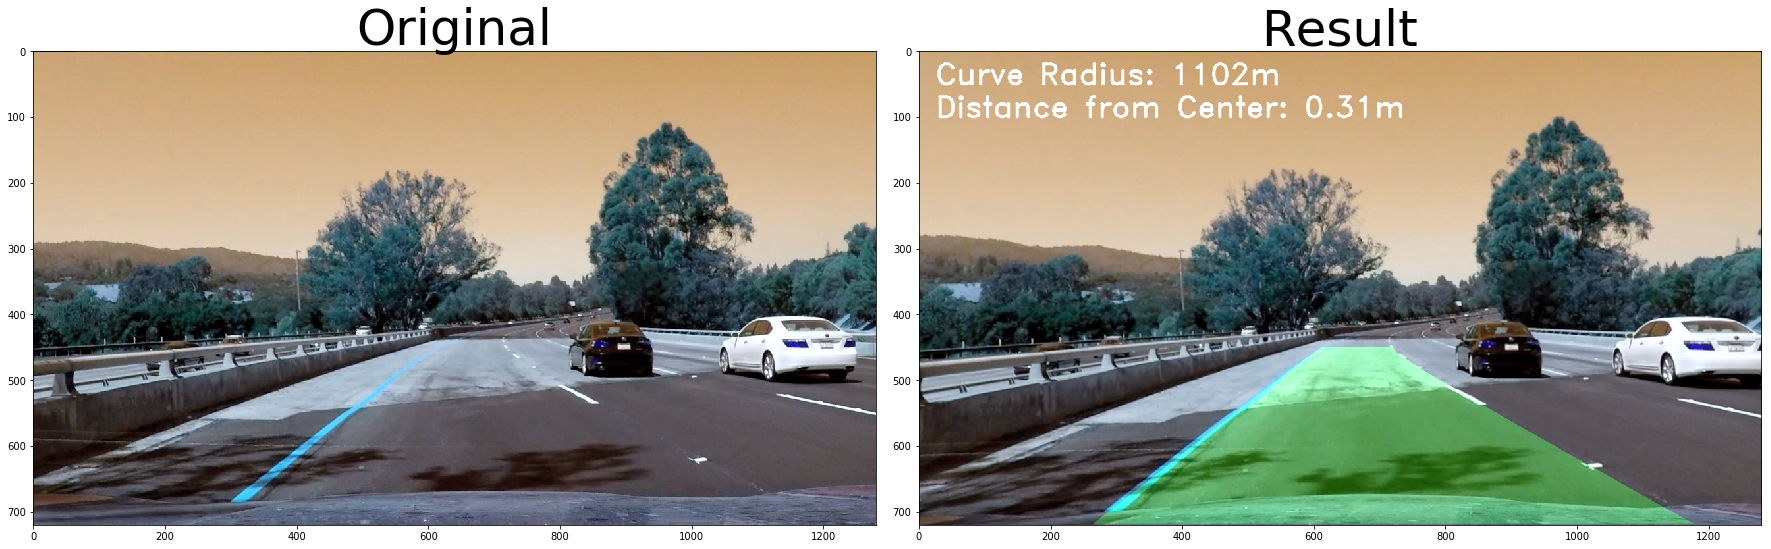

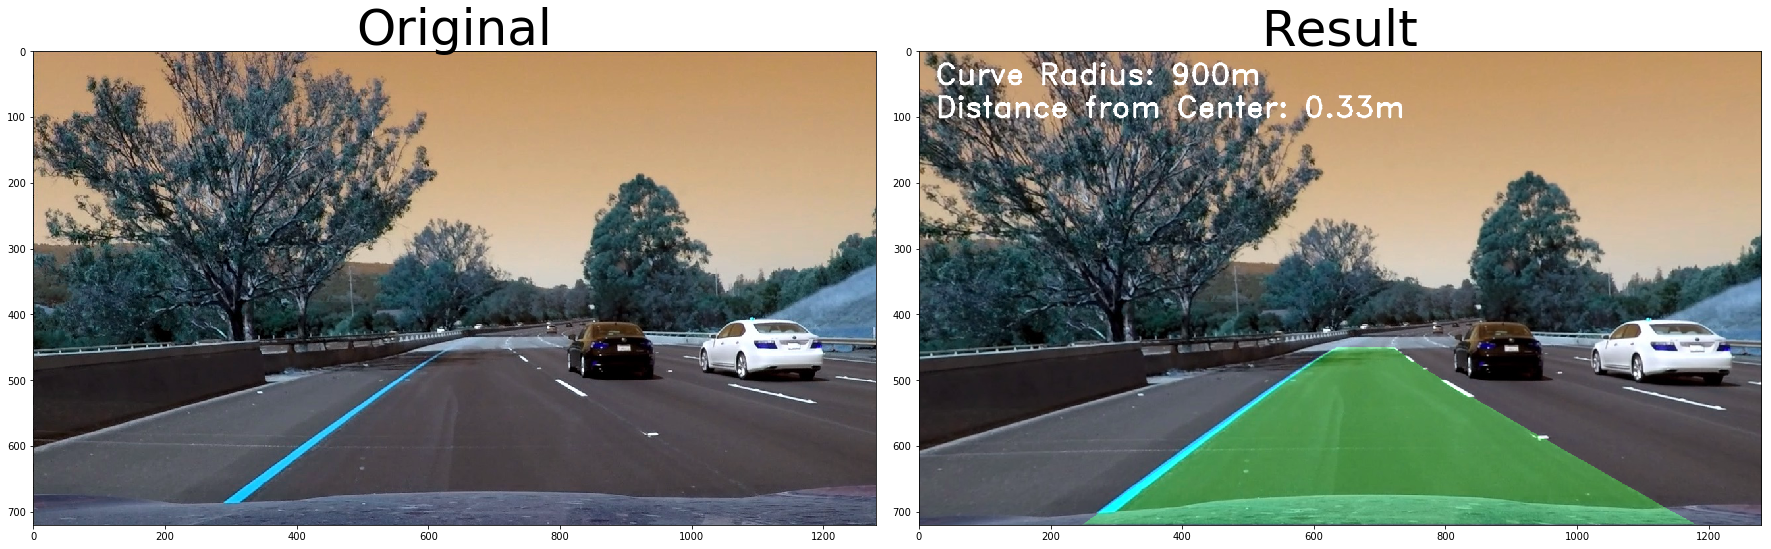

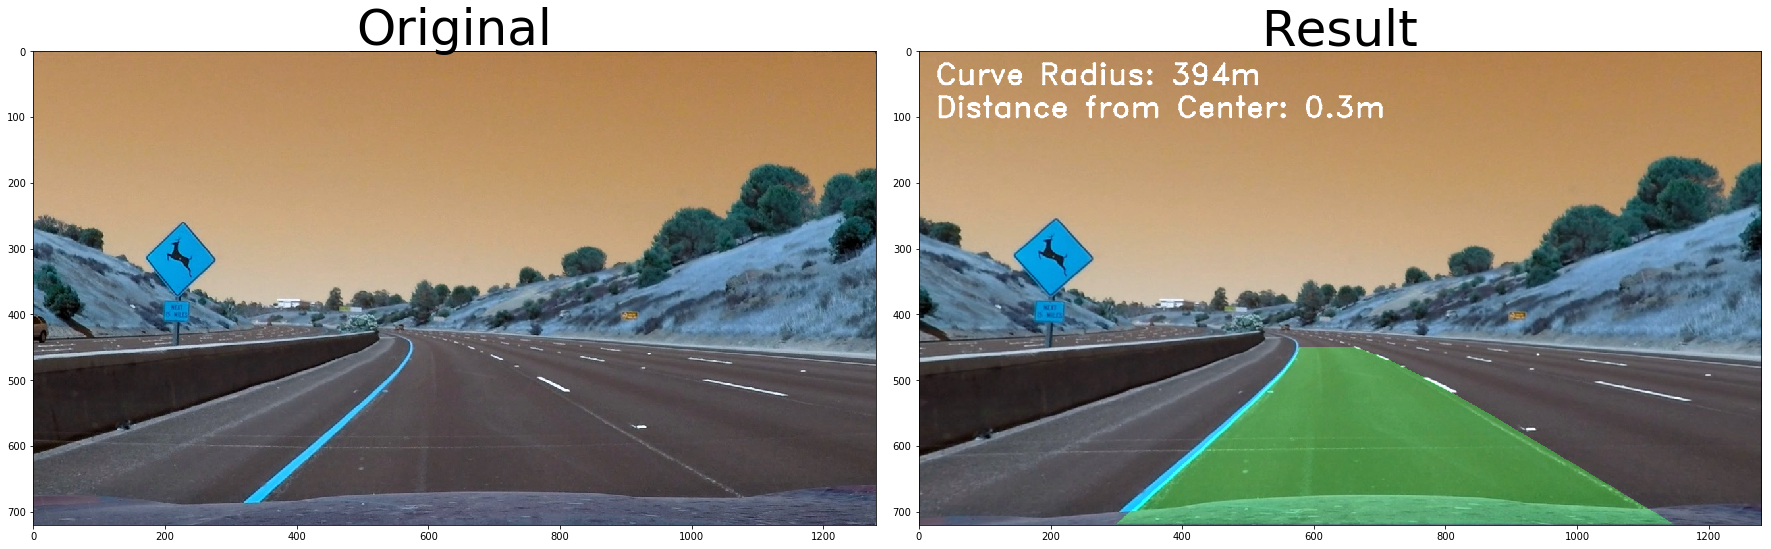

In [4]:
#Import glob of test images
images = glob.glob('test_images/test*.jpg')
#images = glob.glob('test_images/straight_lines*.jpg')

#For each test image in glob
for fname in images:
    
    #Initilize left and right lines
    left_line = Line()
    right_line = Line()
    
    #Read in image
    img = cv2.imread(fname)
    #undistort image from previously calcualted objectpoints and imagepoints
    undist = undistort(img, objpoints, imgpoints)
    #Smooth the image
    kernel_size = 7
    undist_smooth = cv2.GaussianBlur(undist, (kernel_size, kernel_size), 0)
    #Create binary threshold of image
    binary = threshold(undist_smooth)

    #Get image data
    max_x = img.shape[1]
    max_y = img.shape[0]
    #Define points on image to isolate lane - helps remove noise
    vertices = np.array([[(max_x*0.45, max_y*0.61), (max_x*0.14, max_y), (max_x*0.9, max_y), (max_x*0.6, max_y*0.61)]] ,dtype=np.int32)
    #Mask image
    masked_binary = region_of_interest(binary, vertices)
    
    #Warp the masked image into a bird's eye view
    warped, perspective_M, Minv = perspectiveTransform(masked_binary)
    
    
    if left_line.isDetected() and right_line.isDetected():
        #Prior lane data detected, refit window within selected margin
        Lfit = left_line.getFit()
        Rfit = right_line.getFit()
    else:
        #Prior lane data missing for one or more lanes, recalculate entire image with histogram
        Lfit, Rfit = find_lane_pixels(warped, left_line, right_line)
    
    #Fit lines to warped image
    window, ploty, center = search_around_poly(warped, left_line, right_line)
    
    #Retrieve updated lane data
    left_fitx = left_line.getFitx()
    right_fitx = right_line.getFitx()
    left_curve = left_line.getCurve()
    right_curve = right_line.getCurve()
    
    
    ## Visualizations ##
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    ## End Visualizations ##
    
    #Create text to print on image
    font = cv2.FONT_HERSHEY_DUPLEX
    #Add curvature to image
    curve = int(round((left_curve + right_curve) / 2))
    txt = "Curve Radius: " + str(curve) + "m "
    cv2.putText(result, txt, (25,50), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    
    #Add distance to center to image
    if int(center) < 0:
        txt2 = "Distance from Center: " + str(center) + "m left of center"
    elif int(center) > 0:
        txt2 = "Distance from Center: " + str(center) + "m right of center"
    else:
        txt2 = "Distance from Center: " + str(center) + "m"
    cv2.putText(result, txt2, (25,100), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    
    #output original image alongside the calculated image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original', fontsize=50)
    ax2.imshow(result)
    ax2.set_title('Result', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    #Uncomment the following when viewing the bird's eye view image'
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

## Test on Videos

In [5]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#Initilize left and right lines
left_line = Line()
right_line = Line()

def process_image(img):
    #undistort image from previously calcualted objectpoints and imagepoints
    undist = undistort(img, objpoints, imgpoints)
    #Smooth the image
    kernel_size = 7
    undist_smooth = cv2.GaussianBlur(undist, (kernel_size, kernel_size), 0)
    #Create binary threshold of image
    binary = threshold(undist_smooth)

    #Get image data
    max_x = img.shape[1]
    max_y = img.shape[0]
    #Define points on image to isolate lane - helps remove noise
    vertices = np.array([[(max_x*0.45, max_y*0.61), (max_x*0.14, max_y), (max_x*0.9, max_y), (max_x*0.6, max_y*0.61)]] ,dtype=np.int32)
    #Mask image
    masked_binary = region_of_interest(binary, vertices)
     
    #Warp the masked image into a bird's eye view
    warped, perspective_M, Minv = perspectiveTransform(masked_binary)
    
    if left_line.isDetected() and right_line.isDetected():
        #Prior lane data detected, refit window within selected margin
        Lfit = left_line.getFit()
        Rfit = right_line.getFit()
    else:
        #Prior lane data missing for one or more lanes, recalculate entire image with histogram
        Lfit, Rfit = find_lane_pixels(warped, left_line, right_line)

    #Fit lines to warped image
    window, ploty, center = search_around_poly(warped, left_line, right_line)
    
    #Retrieve updated lane data
    left_fitx = left_line.getFitx()
    right_fitx = right_line.getFitx()
    left_curve = left_line.getCurve()
    right_curve = right_line.getCurve()
    
    
    ## Visualizations ##
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    ## End Visualizations ##
    
    #Create text to print on image
    font = cv2.FONT_HERSHEY_DUPLEX
    #Add curvature to image
    curve = int(round((left_curve + right_curve) / 2))
    txt = "Curve Radius: " + str(curve) + "m "
    cv2.putText(result, txt, (25,50), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    
    #Add distance to center to image
    if int(center) < 0:
        txt2 = "Distance from Center: " + str(center) + "m left of center"
    elif int(center) > 0:
        txt2 = "Distance from Center: " + str(center) + "m right of center"
    else:
        txt2 = "Distance from Center: " + str(center) + "m"
    cv2.putText(result, txt2, (25,100), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    
    return result

In [6]:
#Calculate on Project Video
video_output = 'output_images/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
video1 = clip1.fl_image(process_image)
%time video1.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [13:05<00:00,  1.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 10min, sys: 53 s, total: 10min 53s
Wall time: 13min 8s


In [7]:
#Calculate on Challenge Video
video2_output = 'output_images/challenge_video.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
video2 = clip2.fl_image(process_image)
%time video2.write_videofile(video2_output, audio=False)

[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


100%|██████████| 485/485 [04:52<00:00,  1.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

CPU times: user 3min 45s, sys: 19.5 s, total: 4min 4s
Wall time: 4min 55s


In [8]:
#Calculate on Harder Challenge Video
video3_output = 'output_images/harder_challenge_video.mp4'
clip3 = VideoFileClip("harder_challenge_video.mp4")
video3 = clip3.fl_image(process_image)
%time video3.write_videofile(video3_output, audio=False)

[MoviePy] >>>> Building video output_images/harder_challenge_video.mp4
[MoviePy] Writing video output_images/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [13:51<00:00,  1.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_video.mp4 

CPU times: user 10min 13s, sys: 52 s, total: 11min 5s
Wall time: 13min 56s
